# Process Raw Simulation Data Into Realistic Point Clouds

*This workshop is the continuation of the `generate_raw_data` workshop. We assume raw data
has been stored in `~/Workspace/carla_workshop_data`.*

Raw data contains multiple things:
1. Raw upsampled ray casted point cloud (in `$CARLA_WORKSHOP_DATA/frameXX/lidar_pc.npz`).
2. Lidar world transform (in `$CARLA_WORKSHOP_DATA/frameXX/raw_data/lidar_matrix.npz`). This matrix contains
   the information on the position and rotation with respect to the world's frame of reference.
   It will be used in order to have a point cloud relative to the LiDAR.
3. Semantic tags (in `$CARLA_WORKSHOP_DATA/frameXX/tags.npz`). This is used by some shaders.
4. Camera images (in `$CARLA_WORKSHOP_DATA/frameXX/raw_data/CAMERA_TYPE/yawYY/camera_data.npz`).
   There are multiple camera types as information is spread accross different special camera shaders.
5. Camera world inverse transform (in 
   `$CARLA_WORKSHOP_DATA/frameXX/raw_data/CAMERA_TYPE/yawYY/camera_inverse_matrix.npz`).
   Same as for the lidar world
   transform except it contains the inverse transform for cameras. This will be used in order
   to project point clouds onto the camera images.
6. 3D annotations (KITTI format) (in `$CARLA_WORKSHOP_DATA/frameXX/annotations/bboxes_kitti_format.txt`).
   Contains the annotations for all bboxes in the world (occluded or not).
7. 2D camera annotations (in `$CARLA_WORKSHOP_DATA/frameXX/annotations/cam_bboxes/bboxes_kitti_format.txt`).
   These are projected bounding boxes on every camera image. There are other stuff in this directory
   but they are not used.
   
## Processing Data

Processing raw data into point clouds is done using the `ProcessPipeline` object. The pipeline contains
multiple blocks and therefore there are multiple options for generating the point clouds and each of them
have some parameters. In order to visualize everything in a 3D viewer see the `workshop_lidarsimgui`.

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np

from litl_simulator.process_pipelines import ProcessPipeline


CARLA_WORKSHOP_DATA = os.path.expanduser("~/Workspace/carla_workshop_data")

cupy not working...


## Upsampled Point Cloud with Lambertian Reflectance

The simplest point cloud which can be produced is one which is not downsampled (we keep all ray casted points) with objects having a Lambertian Reflectance that is, a reflectance which is only proportional to $\cos\theta$ where $\theta$ is the angle of incidence.

In [2]:
modelling_parameters = {
    "preset_name": "Lambertian_Example",  # This defines the directory name under which processed data will
                                          # be stored. A prefix 'preset_' will be added if needed.
    "thresholding_algorithm": {
        "algorithm": "None",  # Disables thresholding
    },
    "intensity_model": {
        "model": "Lambertian",
    }
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
    loglevel=logging.INFO,  # change this to help debugging
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset. Otherwise an error is thrown
)

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_Lambertian_Example.


### Processed Data Folder Content

If you `cd` into the processed data folder (which would be logged as INFO). You'll see 4 files:
1. `process_metadata.json` which contains the dict of parameters used to make the processed data.
2. `processed_pc.npy` which contains the point cloud coordinates.
3. `processed_iontensities.npy` which contains the processed intensities for each point in the point cloud. This is used when optimizing.
4. `processed_colors.npy` which is the colors array computed from the intensities. Used when displaying the point cloud.

Let's visualize quickly the point cloud with a bird's eyes view:

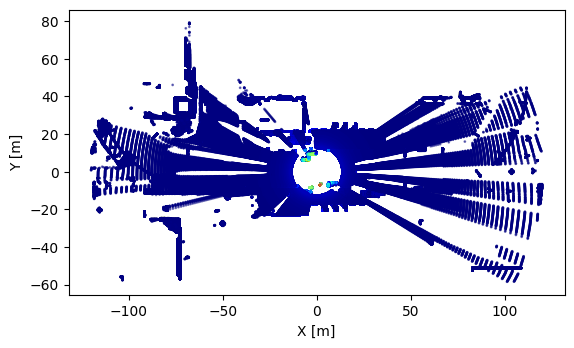

In [3]:
def display_pc(data_dir):
    """Bird's eyes view."""
    pcpath = os.path.join(data_dir, "processed_pc.npy")
    pc = np.load(pcpath)  # nchannels x npts_per_channel array
    colorpath = os.path.join(data_dir, "processed_colors.npy")
    colors = np.load(colorpath)
    colors = np.asarray([colors[..., i].flatten() for i in range(4)]).T
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # this might be slow in case there is a lot of points (e.g.: when not downsampling)
    ax.scatter(pc[..., 0].flatten(), pc[..., 1].flatten(), c=colors, s=1)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_aspect('equal')
    plt.show()
    
display_pc(pipeline.presetdir)

## Downsampling Without Waveforms

There is two downsamplers implemented that do not use waveforms:
1. Max subray downsampler: keep the subray with the maximum intensity.
2. Main subray downsampler: keep the central subray.

Note: a subray is one of the ray from a beam. In other words, when you computed an upsampled point cloud in the previous notebook, you did so (or should have done so) that each channel and each point per channel comes with virtual channels / points that will be combined into a bigger ray. This is to simulate multiple echo reflections around object discontinuities. For example, if `upsampling_ratio=5`, each beam is composed of 5 channels and 5 points per channel totalling 25 ray casts per beam. The `main` ray would be the center one.

Let's test these 2 downsamplers with 2 other shaders.

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_Semantic_max_subray.


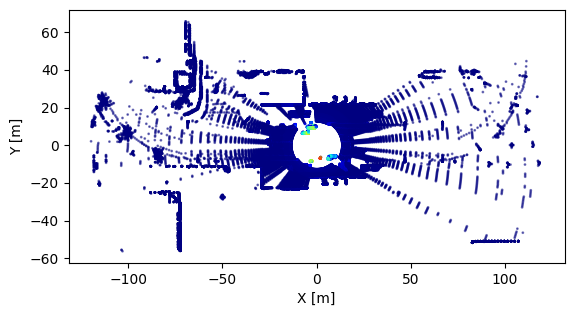

In [4]:
modelling_parameters = {
    "preset_name": "Semantic_max_subray",
    "thresholding_algorithm": {
        "algorithm": "Max Subray Intensity",  # Keep only subray with maximal intensity
                                              # The vertical and horizontal angles are associated with
                                              # the central ray though.
    },
    "intensity_model": {
        "model": "Semantic tag albedo",  # this shader uses the semantic tag and a list of albedos
                                         # in order to compute a reflection intensity ratio.
    }
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_diffuse_color_main_subray.


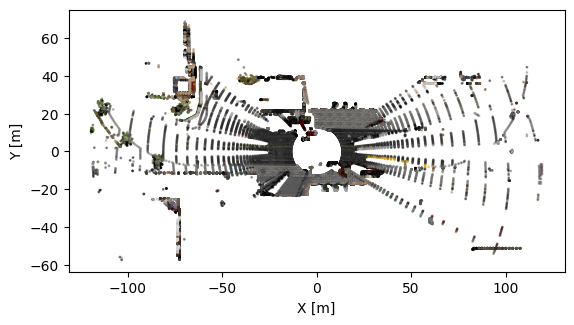

In [5]:
modelling_parameters = {
    "preset_name": "diffuse_color_main_subray",
    "thresholding_algorithm": {
        "algorithm": "Main Ray Only downsampling",  # Keep central subray
    },
    "intensity_model": {
        "model": "Diffuse RGB color",  # this shader projects the point cloud onto the 'diffuse color' images.
                                       # The 'intensity' is now the diffuse color. Useful to check if
                                       # point cloud projection works as expected.
                                       # These are extracted from CARLA using a custom post processing camera
                                       # effect.
    }
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

## Wavefront Generation and Thresholding

To give a more realistic imprint to the processed point cloud, it'd be best to generate waveforms out of the raw point cloud and process them through a simulated LiDAR DSP. There are multiple waveform models but most of them were used during testing. Here's the simplest correct simulation with the AIODrive intensity shader:

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_aiodrive_shader_waveform.


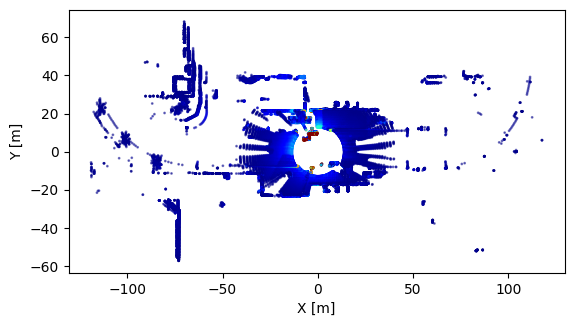

In [6]:
modelling_parameters = {
    "preset_name": "aiodrive_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "GaussTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "uint8",  # cast waveform into uint8 to simulate digitization
        "gaussian_denoizer_sigma": 1.0,  # denoising sigma for ghaussian kernel
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "AIODrive shader",  # Intensity model used by AIODrive. It takes the fully rendered RGB image
                                     # and projects point cloud on it to get infrared albedo then they
                                     # multiply by cos theta and divide by distance squared.
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

The "GaussTemplate" DSP model returns an intensity which corresponds to the waveform height. However, this intensity does not really correspond to the actual target reflectivity. A better DSP (more computer demanding) would first denoise the waveform with the same kernel shape as the laser pulse and then divide by the expected integrated intensity. This is done by the "CosTemplate" DSP model. Here is an example with the NIR shader and `uint16` waveform casting. Note that the denoizing does not take any user-defined extra parameters like the Gaussian DSP.

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_NIR_shader_waveform.


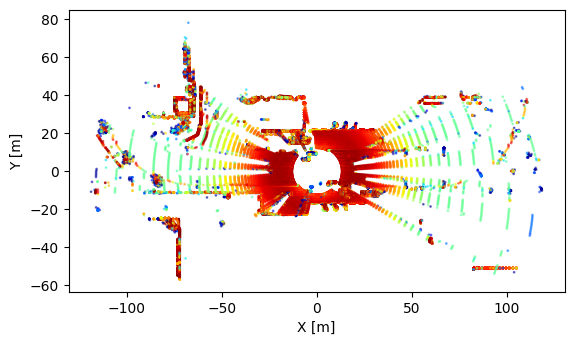

In [7]:
modelling_parameters = {
    "preset_name": "NIR_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "uint16",  # cast waveform into uint16 to simulate digitization
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "NIR model from diffuse color",  # NIR model using the `diffuse_color` image. See paper suppl.
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

## Microfacet Models

Now we can use the roughness/specular/metallic values which defines materials within CARLA combined with a micro facet model in order to simulate specular effects and roughness effects. 2 models are implemented:
1. Oren-Nayar model
2. GGX + Schlick + Disney model (see paper suppl.)

Here they are in action. Also we now turn on the `poissonize_signal` parameter which emulates SPAD sensor quantum behavior with photons.

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_OrenNayar_shader_waveform.


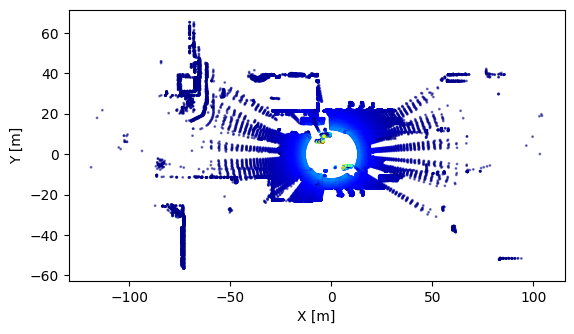

In [8]:
modelling_parameters = {
    "preset_name": "OrenNayar_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "uint16",  # cast waveform into uint16 to simulate digitization
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "NIR + Oren-Nayar roughness models",  # NIR model + Oren-Nayar microfacet model
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
        "poissonize_signal": True,  # Waveform signal is sampled from a Poisson Distribution
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

### Ambient Illumination

All waveforms support the ambient illumination model which adds ambient illumination noise to the waveforms. This is done by projecting the point clouds on the fully rendered RGB image and adding the value to the waveform.

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_CookTorrance_shader_waveform.


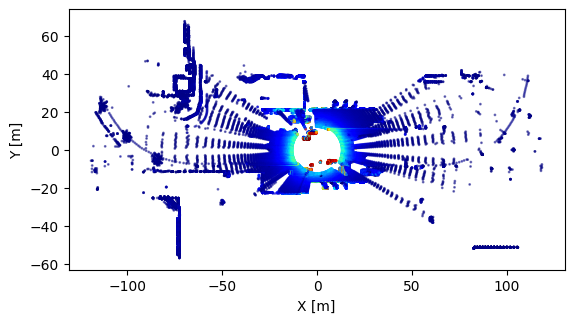

In [9]:
modelling_parameters = {
    "preset_name": "CookTorrance_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "float",  # Preserves waveform in floating point
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "Cook-Torrance",  # Cook Torrance model (same as the one used in paper).
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
        "poissonize_signal": True,  # Waveform signal is sampled from a Poisson Distribution
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
    "ambiant_noise": True,  # Set to True to enable ambiant illumination model
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

### Road Wetness Model

Although this has not been explored in the paper, the road wetness model from the Hahner et al. snow simulation paper has been implemented and should work with all shaders (except the diffuse color one). Here's how to activate it:

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_CookTorrance_wet_shader_waveform.


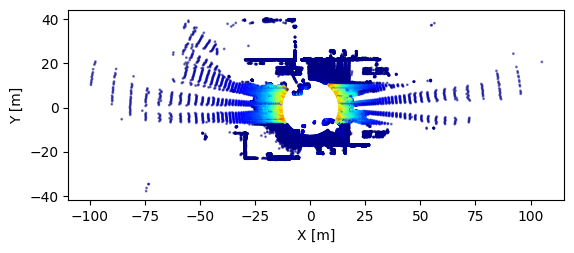

In [10]:
modelling_parameters = {
    "preset_name": "CookTorrance_wet_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "float",  # Preserves waveform in floating point
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "Cook-Torrance",  # Cook Torrance model (same as the one used in paper).
        "road_wetness_depth": 3.0,  # in mm amount of water on the road
        "road_thread_profile_depth": 1.2,  # in mm (see snow paper)
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
        "poissonize_signal": True,  # Waveform signal is sampled from a Poisson Distribution
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
    "ambiant_noise": True,  # Set to True to enable ambiant illumination model
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

## Extra Noise Model

Even though most of the precision comes from the temporal waveform bin sizes, it is possible to add an extra layher of noise using the `noise_model` entries. Here's an example:

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_CookTorrance_wet_shader_waveform.


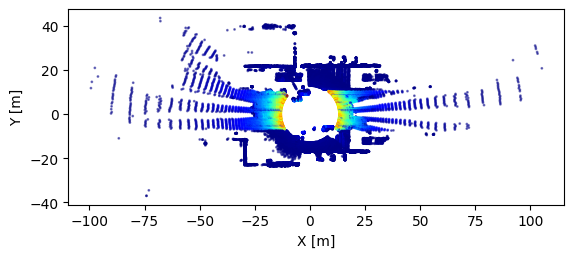

In [11]:
modelling_parameters = {
    "preset_name": "CookTorrance_wet_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "float",  # Preserves waveform in floating point
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "Cook-Torrance",  # Cook Torrance model (same as the one used in paper).
        "road_wetness_depth": 3.0,  # in mm amount of water on the road
        "road_thread_profile_depth": 1.2,  # in mm (see snow paper)
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
        "poissonize_signal": True,  # Waveform signal is sampled from a Poisson Distribution
    },
    "noise_model": {
        "model": "Gaussian noise",  # adds random displacement noise sampled from gaussian distribution
        "std": 6,  # in mm, the gaussian noise FWHM
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
    "ambiant_noise": True,  # Set to True to enable ambiant illumination model
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

### Retro Reflectors Saturation

Lastly, there is an option to delibarately saturate retro reflector objects by using the `saturate_retroreflectors=True` option within the intensity model. However, there is not many things which are considered retroreflectors within the CARLA engine (because of the limited number of semantic tags). Therefore, depending of the other modelling parameters, it can be hard to notice any difference. Here's an example:

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_CookTorrance_wet_shader_waveform.


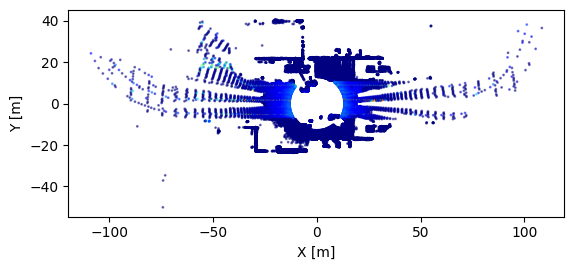

In [12]:
modelling_parameters = {
    "preset_name": "CookTorrance_wet_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "float",  # Preserves waveform in floating point
        "noise_floor_threshold": 1.0,  # rising edge threshold
    },
    "intensity_model": {
        "model": "Cook-Torrance",  # Cook Torrance model (same as the one used in paper).
        "road_wetness_depth": 3.0,  # in mm amount of water on the road
        "road_thread_profile_depth": 1.2,  # in mm (see snow paper)
        "saturate_retro_reflectors": True,
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": 5,  # in ns. Laser pulse width
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
        "poissonize_signal": True,  # Waveform signal is sampled from a Poisson Distribution
    },
    "noise_model": {
        "model": "Gaussian noise",  # adds random displacement noise sampled from gaussian distribution
        "std": 6,  # in mm, the gaussian noise FWHM
    },
    "snr": 200,  # approximate signal-to-noise ratio. Actually this corresponds to laser power P0.
    "saturation": 1000,  # saturation level beyond which the waveform is clipped
    "ambiant_noise": True,  # Set to True to enable ambiant illumination model
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)

## Channel-Wise Settings

Some parameters can be passed as lists and be customized for each laser channel: `snr`, `tauH` and `noise_floor_threshold` are the only ones to support this. Here's an example with 128 channels grouped in 2 subgroups of 64 channels. BTW, when using this feature, the first index (0) is associated with the channel with highest vertical angle.

INFO:ProcessPipeline:Saving processed data to: /home/felix.goudreault/Workspace/carla_workshop_data/frame0/processed_data/preset_CookTorrance_wet_shader_waveform.


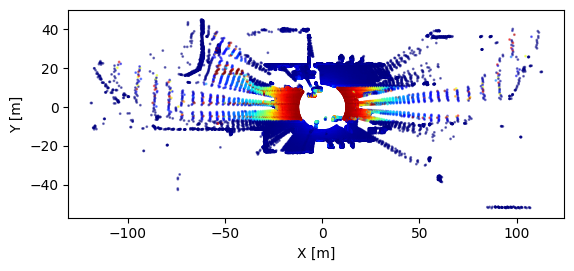

In [13]:
modelling_parameters = {
    "preset_name": "CookTorrance_wet_shader_waveform",
    "thresholding_algorithm": {
        "algorithm": "Rising Edge and pulse params",  # Detects when waveform passes the given threshold
        "dsp_template": "CosTemplate",  # applies gaussian denoizing
        "gain": 0.0,  # power gain in waveform
        "digitization": "float",  # Preserves waveform in floating point
        "noise_floor_threshold": [1.0] * 64 + [0.1] * 64,  # rising edge threshold
    },
    "intensity_model": {
        "model": "Cook-Torrance",  # Cook Torrance model (same as the one used in paper).
        "road_wetness_depth": 3.0,  # in mm amount of water on the road
        "road_thread_profile_depth": 1.2,  # in mm (see snow paper)
        "saturate_retro_reflectors": True,
    },
    "waveform_model": {
        "model": "SinSquared",  # there is also SinSquaredGPU which does the computation on GPU (much faster)
        "tauH": [5] * 64 + [10] * 64,
        "waveform_resolution": 2400,  # number of waveform bins. determines range resolution with min/max.
        "waveform_range": 120,  # in meters, determines maximum waveform timebin.
        "waveform_min_dist": 1,  # in meters, determines minimum waveform timebin.
        "upsampling_ratio": 5,  # number of channels and pts_per_channel per beam
        "poissonize_signal": True,  # Waveform signal is sampled from a Poisson Distribution
    },
    "noise_model": {
        "model": "Gaussian noise",  # adds random displacement noise sampled from gaussian distribution
        "std": 6,  # in mm, the gaussian noise FWHM
    },
    "snr": [200] * 64 + [500] * 64,
    "ambiant_noise": True,  # Set to True to enable ambiant illumination model
}

pipeline = ProcessPipeline(
    modelling_parameters,
    framedir=os.path.join(CARLA_WORKSHOP_DATA, "frame0"),
)
pipeline.process(
    overwrite=True,  # set to True to overwrite preset
)

display_pc(pipeline.presetdir)